<center><H1>Task 3</H1></center>

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
tqdm.pandas()
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# read datasets
all = pd.read_csv('/kaggle/input/hespressall/all.csv')

## **Split each class to 80% train and 20% test**

In [3]:
# Initialize empty lists to store train and test data
train_data = []
test_data = []

# Group the data by class
grouped_data = all.groupby('topic')[['stemmed_story', 'stemmed_title']]

# Split the data per class
for topic, group in grouped_data:
    train_group, test_group = train_test_split(group, train_size=800, test_size=200, random_state=42)
    train_data.append(pd.DataFrame({'stemmed_story': train_group['stemmed_story'].values,
                                    'stemmed_title': train_group['stemmed_title'].values,
                                    'topic': topic}))
    test_data.append(pd.DataFrame({'stemmed_story': test_group['stemmed_story'].values,
                                   'stemmed_title': test_group['stemmed_title'].values,
                                   'topic': topic}))

# Concatenate the DataFrames for train and test data
train_data = pd.concat(train_data, ignore_index=True)
test_data = pd.concat(test_data, ignore_index=True)


In [4]:
# Concatenate 'stemmed_story' and 'stemmed_title' columns as features for train and test sets
X_train = train_data['stemmed_story'] + ' ' + train_data['stemmed_title']
y_train = train_data['topic']
X_test = test_data['stemmed_story'] + ' ' + test_data['stemmed_title']
y_test = test_data['topic']

# Initialize the vectorizer
vectorizer = TfidfVectorizer()
# Transform the training data using the vectorizer
X_train_vectorized = vectorizer.fit_transform(X_train)
# Transform the test data using the same vectorizer
X_test_vectorized = vectorizer.transform(X_test)

## **Naive Bayes with GridSearch**

In [5]:
# Build a Naive Bayes classifier
nb_classifier = MultinomialNB()

# Define the hyperparameter grid for Naive Bayes
param_grid = {
    'alpha': [0.1, 1.0, 2.0],  # The smoothing parameter
    'fit_prior': [True, False],  # Whether to learn class prior probabilities or not
}

# Perform GridSearchCV for hyperparameter tuning
grid_search_nb = GridSearchCV(nb_classifier, param_grid, cv=5)
grid_search_nb.fit(X_train_vectorized, y_train)

# Get the best classifier with tuned hyperparameters
nb_classifier = grid_search_nb.best_estimator_

# best hyperparameters
print("alpha: ",grid_search_nb.best_estimator_.alpha)
print("fit_prior: ",grid_search_nb.best_estimator_.fit_prior)

alpha:  0.1
fit_prior:  True


In [6]:
# Make predictions
y_pred = nb_classifier.predict(X_test_vectorized)

# Calculate accuracy and print the classification report
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.78

Classification Report:
                    precision    recall  f1-score   support

    art-et-culture       0.87      0.84      0.85       200
          economie       0.83      0.79      0.81       200
      faits-divers       0.96      0.82      0.89       200
marocains-du-monde       0.88      0.71      0.79       200
            medias       0.48      0.89      0.62       200
           orbites       0.61      0.67      0.64       200
         politique       0.82      0.70      0.76       200
           regions       0.84      0.66      0.74       200
           societe       0.72      0.60      0.66       200
             sport       1.00      0.95      0.98       200
         tamazight       0.91      0.92      0.92       200

          accuracy                           0.78      2200
         macro avg       0.81      0.78      0.79      2200
      weighted avg       0.81      0.78      0.79      2200



In [7]:
# Calculate and print accuracy per class
class_accuracy = {}
unique_classes = y_test.unique()
for class_label in unique_classes:
    # Get the indices for the specific class in y_test and y_pred
    class_idx = y_test[y_test == class_label].index
    # Calculate accuracy for the specific class
    class_accuracy[class_label] = accuracy_score(y_test.loc[class_idx], pd.Series(y_pred).loc[class_idx])

print("\nAccuracy per class:")
for class_label, acc in class_accuracy.items():
    print(f"{class_label}: {acc:.2f}")


Accuracy per class:
art-et-culture: 0.84
economie: 0.79
faits-divers: 0.82
marocains-du-monde: 0.71
medias: 0.89
orbites: 0.67
politique: 0.70
regions: 0.66
societe: 0.60
sport: 0.95
tamazight: 0.92


## **SVM with GridSearch**

In [8]:
# Build a Linear SVC model
svc_classifier = LinearSVC()

# Define the hyperparameter grid for Linear SVC
param_grid = {
    'C': [0.1, 1, 10],
    'loss': ['hinge', 'squared_hinge'],
}

# Perform GridSearchCV for hyperparameter tuning
grid_search_svc = GridSearchCV(svc_classifier, param_grid, cv=5)
grid_search_svc.fit(X_train_vectorized, y_train)

# Get the best classifier with tuned hyperparameters
svc_classifier = grid_search_svc.best_estimator_

# best hyperparameters
print("C: ",grid_search_svc.best_estimator_.C)
print("Loss: ",grid_search_svc.best_estimator_.loss)

C:  1
Loss:  squared_hinge


In [9]:
# Make predictions and evaluate the model
y_pred = svc_classifier.predict(X_test_vectorized)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.85

Classification Report:
                    precision    recall  f1-score   support

    art-et-culture       0.87      0.90      0.88       200
          economie       0.82      0.84      0.83       200
      faits-divers       0.92      0.92      0.92       200
marocains-du-monde       0.84      0.88      0.86       200
            medias       0.96      0.89      0.92       200
           orbites       0.67      0.64      0.66       200
         politique       0.77      0.76      0.77       200
           regions       0.78      0.81      0.80       200
           societe       0.74      0.72      0.73       200
             sport       0.99      0.99      0.99       200
         tamazight       0.96      0.96      0.96       200

          accuracy                           0.85      2200
         macro avg       0.85      0.85      0.85      2200
      weighted avg       0.85      0.85      0.85      2200



In [10]:
# Calculate and print accuracy per class
class_accuracy = {}
unique_classes = y_test.unique()
for class_label in unique_classes:
    # Get the indices for the specific class in y_test and y_pred
    class_idx = y_test[y_test == class_label].index
    # Calculate accuracy for the specific class
    class_accuracy[class_label] = accuracy_score(y_test.loc[class_idx], pd.Series(y_pred).loc[class_idx])

print("\nAccuracy per class:")
for class_label, acc in class_accuracy.items():
    print(f"{class_label}: {acc:.2f}")


Accuracy per class:
art-et-culture: 0.90
economie: 0.84
faits-divers: 0.92
marocains-du-monde: 0.88
medias: 0.89
orbites: 0.64
politique: 0.76
regions: 0.81
societe: 0.72
sport: 0.99
tamazight: 0.96


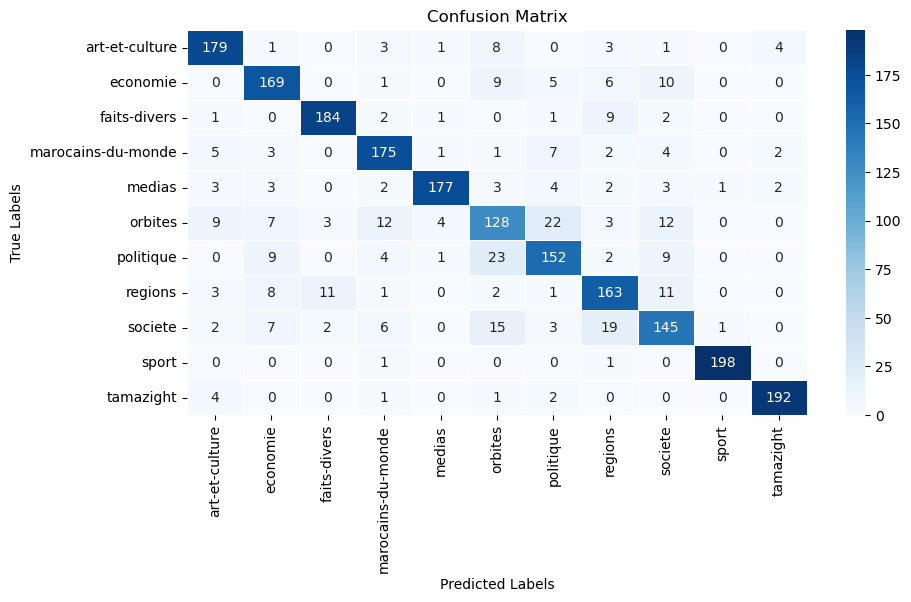

In [11]:
# Get the unique classes in the dataset (assuming they are integers or strings)
unique_classes = np.unique(np.concatenate((y_test, y_pred)))

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=unique_classes)

# Create a DataFrame to display the confusion matrix
confusion_df = pd.DataFrame(cm, index=unique_classes, columns=unique_classes)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(confusion_df, annot=True, cmap='Blues', fmt='d', linewidths=0.5) # formats the cell annotations as integers
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


1. **Accuracy:** represents the proportion of correctly predicted instances (both true positives and true negatives) over the total number of instances in the dataset. It provides an overall measure of how well the model performs across all classes. However, it may not be the best metric for imbalanced datasets, where one class dominates the others, as high accuracy can be achieved by simply predicting the majority class.

2. **Precision:** focuses on the correct positive predictions made by the model. It is the ratio of true positives to the sum of true positives and false positives (instances predicted as positive but are actually negative). 

3. **Recall (Sensitivity):** measures the ability of the model to identify positive instances correctly. It is the ratio of true positives to the sum of true positives and false negatives (instances predicted as negative but are actually positive)

4. **F1-score:** it provides a balance between precision and recall. The F1-score considers both false positives and false negatives and provides a single score that reflects the model's performance.

**Mathematically, these metrics can be expressed as follows:**
- Accuracy: (True Positives + True Negatives) / Total instances
- Precision: True Positives / (True Positives + False Positives)
- Recall: True Positives / (True Positives + False Negatives)
- F1-score: 2 * (Precision * Recall) / (Precision + Recall)


**Enhancements to increase model accuracy**
- model can't calssify orbites, politique and societe well
- i think there are no enough unique words for these classes to determine how relevant those words are to a given document, I think there is a contradiction between stories or titles for these classes.
- i think these classes need to have more relevant stories or titles
- we can use transformers to increase accuracy